In [23]:
import pandas as pd
import numpy as np
from tempeh.configurations import datasets

compas_dataset = datasets["compas"]()
X_train, X_test = compas_dataset.get_X(format=pd.DataFrame)
y_train, y_test = compas_dataset.get_y(format=pd.Series)
(
    sensitive_features_train,
    sensitive_features_test,
) = compas_dataset.get_sensitive_features("race", format=pd.Series)
X_train.loc[0], y_train[0]

(age                        25.000000
 juv_fel_count               0.000000
 juv_misd_count             -2.340451
 juv_other_count             1.000000
 priors_count              -15.010999
 age_cat_25 - 45             1.000000
 age_cat_Greater than 45     0.000000
 age_cat_Less than 25        0.000000
 c_charge_degree_F           0.000000
 c_charge_degree_M           1.000000
 Name: 0, dtype: float64,
 1.0)

In [26]:
sensitive_features_train._name = 'race2'

In [27]:
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(solver="liblinear")
estimator.fit(X_train, y_train)

LogisticRegression(solver='liblinear')


equalized odds with postprocessed model on test data:
P[recidivism predicted | African-American]                = 0.46108949416342415
P[recidivism predicted | African-American, recidivism]    = 0.5686274509803921
P[recidivism predicted | African-American, no recidivism] = 0.33190578158458245
P[recidivism predicted | Caucasian]                       = 0.4677871148459384
P[recidivism predicted | Caucasian, recidivism]           = 0.6236162361623616
P[recidivism predicted | Caucasian, no recidivism]        = 0.3724604966139955


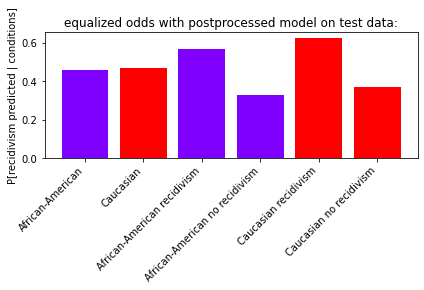

In [28]:
from sklearn import clone
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError


class LogisticRegressionAsRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, logistic_regression_estimator):
        self.logistic_regression_estimator = logistic_regression_estimator

    def fit(self, X, y):
        try:
            check_is_fitted(self.logistic_regression_estimator)
            self.logistic_regression_estimator_ = self.logistic_regression_estimator
        except NotFittedError:
            self.logistic_regression_estimator_ = clone(
                self.logistic_regression_estimator
            ).fit(X, y)
        return self

    def predict(self, X):
        # use predict_proba to get real values instead of 0/1, select only prob for 1
        scores = self.logistic_regression_estimator_.predict_proba(X)[:, 1]
        return scores


from fairlearn.postprocessing import ThresholdOptimizer

estimator_wrapper = LogisticRegressionAsRegression(estimator).fit(X_train, y_train)
postprocessed_predictor_EO = ThresholdOptimizer(
    estimator=estimator_wrapper, constraints="equalized_odds", prefit=True
)

postprocessed_predictor_EO.fit(
    X_train, y_train, sensitive_features=sensitive_features_train
)

fairness_aware_predictions_EO_train = postprocessed_predictor_EO.predict(
    X_train, sensitive_features=sensitive_features_train
)
fairness_aware_predictions_EO_test = postprocessed_predictor_EO.predict(
    X_test, sensitive_features=sensitive_features_test
)

# show only test data related plot by default - uncomment the next line to see
# training data plot as well

# show_proportions(
#     X_train, sensitive_features_train, fairness_aware_predictions_EO_train,
#     y_train,
#     description="equalized odds with postprocessed model on training data:",
#     plot_row_index=1)
show_proportions(
    X_test,
    sensitive_features_test,
    fairness_aware_predictions_EO_test,
    y_test,
    description="equalized odds with postprocessed model on test data:",
    plot_row_index=2,
)
plt.show()

In [29]:
scores = estimator_wrapper.predict(X_train)
scores

array([0.08323404, 0.43451484, 0.54980294, ..., 0.56740062, 0.22122327,
       0.37423461])

In [30]:
from fairlearn.postprocessing._threshold_optimizer import _reformat_and_group_data

data_grouped_by_sensitive_feature = _reformat_and_group_data(
    sensitive_features_train, y_train.astype(int), scores
)
data_grouped_by_sensitive_feature.describe()

from fairlearn.postprocessing._roc_curve_utilities import _calculate_roc_points

roc_points = {}
for group_name, group in data_grouped_by_sensitive_feature:
    roc_points[group_name] = _calculate_roc_points(
        data_grouped_by_sensitive_feature.get_group(group_name), 0
    )
print("Thresholding rules:")


Thresholding rules:


In [22]:
sensitive_features_train

0       African-American
1              Caucasian
2              Caucasian
3       African-American
4              Caucasian
              ...       
3531    African-American
3532    African-American
3533    African-American
3534    African-American
3535    African-American
Name: race, Length: 3536, dtype: object

In [11]:
n_group_0 = {}

n_group_1 = {}
for group_name, group in data_grouped_by_sensitive_feature:
    print("{}:".format(group_name))
    n_group_1[group_name] = sum(group["label"])
    n_group_0[group_name] = len(group) - n_group_1[group_name]

    print("    number of samples with label 1: {}".format(n_group_1[group_name]))
    print("    number of samples with label 0: {}".format(n_group_0[group_name]))

threshold = 0.5
for group_name, group in data_grouped_by_sensitive_feature:
    x_group_0_5 = (
        sum((group["score"] > threshold) & (group["label"] == 0))
        / n_group_0[group_name]
    )
    y_group_0_5 = (
        sum((group["score"] > threshold) & (group["label"] == 1))
        / n_group_1[group_name]
    )
    print("{}:".format(group_name))
    print("    P[Ŷ = 1 | Y = 0] = {}".format(x_group_0_5))
    print("    P[Ŷ = 1 | Y = 1] = {}".format(y_group_0_5))

African-American:
    number of samples with label 1: 1100
    number of samples with label 0: 1047
Caucasian:
    number of samples with label 1: 551
    number of samples with label 0: 838
African-American:
    P[Ŷ = 1 | Y = 0] = 0.34001910219675263
    P[Ŷ = 1 | Y = 1] = 0.6854545454545454
Caucasian:
    P[Ŷ = 1 | Y = 0] = 0.1801909307875895
    P[Ŷ = 1 | Y = 1] = 0.4010889292196007


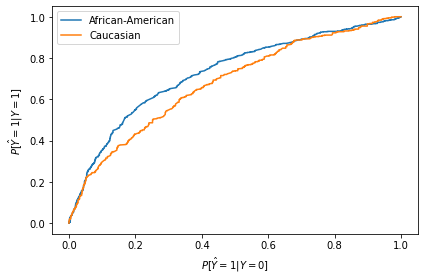

In [12]:
for group_name, group in data_grouped_by_sensitive_feature:
    plt.plot(roc_points[group_name].x, roc_points[group_name].y, label=group_name)
    
plt.xlabel("$P [ \\hat{Y}=1 | Y=0 ]$")
plt.ylabel("$P [ \\hat{Y}=1 | Y=1 ]$")
plt.legend()
plt.show()

In [13]:
postprocessed_predictor_EO._plot = True
postprocessed_predictor_EO.fit(
    X_train, y_train, sensitive_features=sensitive_features_train
)

for (
    group,
    interpolation,
) in postprocessed_predictor_EO._post_processed_predictor_by_sensitive_feature.items():
    print("{}:".format(group))
    print("\n ".join(interpolation.__repr__().split(",")))
    print("-----------------------------------")

African-American:
[p_ignore: 0.23207031263141853
  prediction_constant: 0.337
  p0: 0.6265294117647058
  operation0: [>0.5255937372948385]
  p1: 0.3734705882352942
  operation1: [>0.45115774437313916]]
-----------------------------------
Caucasian:
[p_ignore: 0.0
  prediction_constant: 0.337
  p0: 0.003735849056603747
  operation0: [>0.5172897195295316]
  p1: 0.9962641509433963
  operation1: [>0.40323605733701384]]
-----------------------------------
